# Results for ICAIF '23 paper "Gradient-assisted calibration for financial agent-based models", Dyer et al. (2023)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from blackbirds.infer import VI
from blackbirds.models.rama_cont import RamaCont
from blackbirds.losses import SingleOutput_SimulateAndMMD

In [3]:
import scienceplots
import matplotlib.pyplot as plt
plt.style.use("science")

import numpy as np
import torch
import normflows as nf
import pygtc
import pandas as pd

import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2023/bin/universal-darwin'

## Fix seed for reproducibility

In [4]:
torch.manual_seed(101)

## Define model

In [5]:
class LogModel(RamaCont):
    def initialize(self, params):
        return super().initialize(10 ** params)
    def step(self, params, x):
        return super().step(10 ** params, x)

In [6]:
model = LogModel(n_agents = 1000, n_timesteps=100, s=0.1, sigmoid_k=5.0)

## Define loss to use in GVI procedure

In [7]:
class MMDLoss:
    def __init__(self, *args, offset=0., **kwargs):
        self.mmd_calculator = SingleOutput_SimulateAndMMD(*args, **kwargs)
        self.offset = offset
        
    def __call__(self, *args, **kwargs):
        loss = self.mmd_calculator(*args, **kwargs)
        return loss - self.offset

## Generate "true" data set

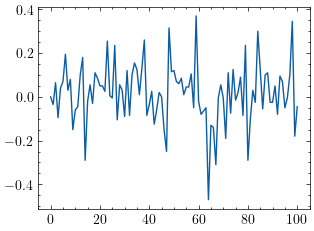

In [8]:
true_parameters = torch.log10(torch.tensor([0.1, 0.5, 0.5, 0.2]))
true_data = model.run_and_observe(true_parameters)
_ = plt.plot(true_data[0])

## Define posterior estimator

In [9]:
def make_flow():
    torch.manual_seed(1)
    base = nf.distributions.base.DiagGaussian(len(true_parameters))
    num_layers = 5
    latent_size = len(true_parameters)
    flows = []
    for i in range(num_layers):
        param_map = nf.nets.MLP([2, 50, 50, latent_size], init_zeros=True)
        flows.append(nf.flows.AffineCouplingBlock(param_map))
        flows.append(nf.flows.Permute(latent_size, mode='swap'))
    return nf.NormalizingFlow(base, flows)

## Get results with pathwise gradient estimator

In [10]:
prior = torch.distributions.MultivariateNormal(torch.zeros(4), 1.0 * torch.eye(len(true_parameters)))
path_estimator = make_flow()
torch.manual_seed(2)
loss = MMDLoss(model=model, y=true_data[0], offset=1.)
optimizer = torch.optim.AdamW(path_estimator.parameters(), lr=1e-3)
vi = VI(loss=loss, 
        posterior_estimator=path_estimator, 
        prior=prior, 
        optimizer=optimizer, 
        n_samples_per_epoch=10,
        w=0.001,
        log_tensorboard=True,
        gradient_estimation_method="pathwise",
        gradient_clipping_norm=1.0)

vi.run(true_data[0], n_epochs=300, max_epochs_without_improvement=300);

100%|███████████████████████████████████████████████████████████████████████████████████████| 300/300 [03:26<00:00,  1.46it/s, loss=-.995, reg.=0.00554, total=-.99, best loss=-1, epochs since improv.=133]


In [11]:
sum(p.numel() for p in path_estimator.parameters() if p.requires_grad)

14528

### Load the best model to check the results

In [12]:
path_estimator.load_state_dict(vi.best_estimator_state_dict)

<All keys matched successfully>

In [13]:
with torch.no_grad():
    log_posterior_density_of_true_parameters = path_estimator.log_prob(true_parameters.unsqueeze(0))
    print(log_posterior_density_of_true_parameters)
    path_samples = path_estimator.sample(10000)[0].detach().numpy()

tensor([-2.6348])


## Get results with score gradient estimator

In [14]:
score_estimator = make_flow()
torch.manual_seed(2)
loss = MMDLoss(model=model, y=true_data[0], offset=1.)
optimizer = torch.optim.AdamW(score_estimator.parameters(), lr=1e-3)
vi = VI(loss=loss, 
        posterior_estimator=score_estimator, 
        prior=prior, 
        optimizer=optimizer, 
        n_samples_per_epoch=10,
        w=0.001,
        log_tensorboard=True,
        gradient_estimation_method="score",
        gradient_clipping_norm=1.0)

vi.run(true_data[0], n_epochs=300, max_epochs_without_improvement=300);

100%|███████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:39<00:00,  3.01it/s, loss=-.839, reg.=0.01, total=-.829, best loss=-.933, epochs since improv.=94]


In [15]:
sum(p.numel() for p in score_estimator.parameters() if p.requires_grad)

14528

### Load the best model to check the results

In [16]:
score_estimator.load_state_dict(vi.best_estimator_state_dict)

<All keys matched successfully>

In [17]:
with torch.no_grad():
    log_posterior_density_of_true_parameters = score_estimator.log_prob(true_parameters.unsqueeze(0))
    print(log_posterior_density_of_true_parameters)
    score_samples = score_estimator.sample(10000)[0].detach().numpy()

tensor([nan])


In this case, the score-based posterior assigns almost 0 density to the values of the true parameters.

## Plot posteriors

In [18]:
samples_prior = prior.sample((10000,)).numpy()

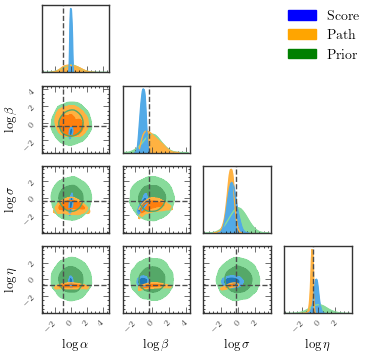

In [19]:
try:
    pygtc.plotGTC([score_samples, path_samples, samples_prior, ], 
                  figureSize=4, truths = true_parameters.numpy(), 
                  chainLabels = ["Posterior (score)", "Posterior (path)", "Prior", ], 
                  paramNames = [r"$\log\alpha$", r"$\log\beta$", r"$\log\sigma$", r"$\log\eta$"],
                  colorsOrder=['blues', 'oranges', 'greens_old', 'browns', 'pinks', 'grays', 'reds', 'greens', 'purples',
                               'yellows', 'cyans']);
except AttributeError:
    import matplotlib.patches as mpatches
    score = mpatches.Patch(color='blue', label='Score')
    path = mpatches.Patch(color='orange', label='Path')
    prior = mpatches.Patch(color='green', label='Prior')
    plt.gcf().legend(handles=[score, path, prior], loc='upper right', bbox_to_anchor=(.95,0.9))

## Visualise samples from predictive distributions

### Pathwise with control variate 1

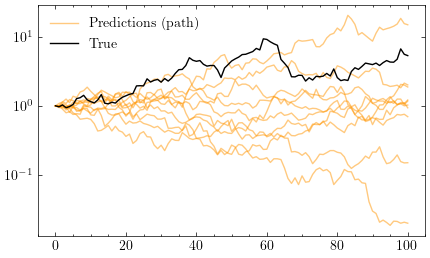

In [20]:
n_samples = 10

path_preds = []
    
f, ax = plt.subplots(figsize=(5, 3))
j = 0
while j < n_samples:
    with torch.no_grad():
        prediction = model.run_and_observe(path_estimator.sample((1))[0][0])[0]
        i = 0
        while torch.isnan(prediction).any():
            prediction = model.run_and_observe(path_estimator.sample((1))[0][0])[0]
            i += 1
            if i > 100:
                print("Failed")
                break
    j += 1
    pred_prices = torch.cumprod(torch.exp(prediction.cpu()), dim=0)
    path_preds.append(pred_prices)
    ax.plot(pred_prices, color = "C2", alpha=0.5)
true_prices = torch.cumprod(torch.exp(true_data[0]), dim=0)
ax.plot(true_prices, color = "black")
    
ax.plot([], [], color = "C2", label ="Predictions (path)", alpha=0.5)
ax.plot([], [], color="black", label="True")

ax.set_yscale("symlog", linthresh=0.1)

ax.legend()

# plt.savefig("./ICAIF_plots/score_preds.pdf", format='pdf', bbox_inches='tight', dpi=300)

### Score with control variate 1

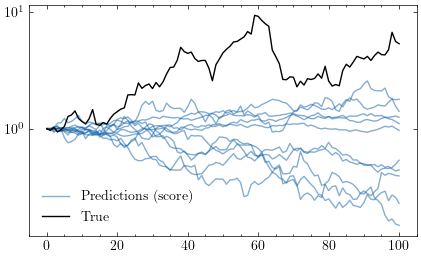

In [21]:
n_samples = 10

score_preds = []
    
f, ax = plt.subplots(figsize=(5, 3))
j = 0
while j < n_samples:
    with torch.no_grad():
        prediction = model.run_and_observe(score_estimator.sample((1))[0][0])[0]
        i = 0
        while torch.isnan(prediction).any():
            prediction = model.run_and_observe(score_estimator.sample((1))[0][0])[0]
            i += 1
            if i > 100:
                print("Failed")
                break
    j += 1
    pred_prices = torch.cumprod(torch.exp(prediction.cpu()), dim=0)
    score_preds.append(pred_prices)
    ax.plot(pred_prices, color = "C0", alpha=0.5)
true_prices = torch.cumprod(torch.exp(true_data[0]), dim=0)
ax.plot(true_prices, color = "black")
    
ax.plot([], [], color = "C0", label ="Predictions (score)", alpha=0.5)
ax.plot([], [], color="black", label="True")

ax.set_yscale("symlog", linthresh=0.1)

ax.legend()

# plt.savefig("./ICAIF_plots/score_preds.pdf", format='pdf', bbox_inches='tight', dpi=300)

(0.020361335347928156, 29.070587778836984)

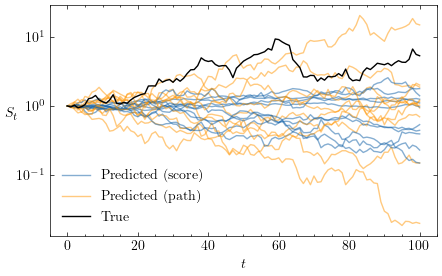

In [22]:
f, ax = plt.subplots(figsize=(5, 3))
for s_prices, p_prices in zip(score_preds, path_preds):
    ax.plot(s_prices, color = "C0", alpha=0.5)
    ax.plot(p_prices, color = "C2", alpha=0.5)
true_prices = torch.cumprod(torch.exp(true_data[0]), dim=0)
ax.plot(true_prices, color = "black")
    
ax.plot([], [], color = "C0", label ="Predicted (score)", alpha=0.5)
ax.plot([], [], color = "C2", label ="Predicted (path)", alpha=0.5)
ax.plot([], [], color="black", label="True")

ax.set_yscale("symlog", linthresh=0.1)

ax.legend()
ax.set_ylabel(r"$S_t$", rotation=0)#, fontsize=12)
ax.set_xlabel(r"$t$")#, fontsize=12)

ax.get_ylim()

# plt.savefig("./ICAIF_plots/score_path_preds.pdf", format='pdf', bbox_inches='tight', dpi=300)

### Prior

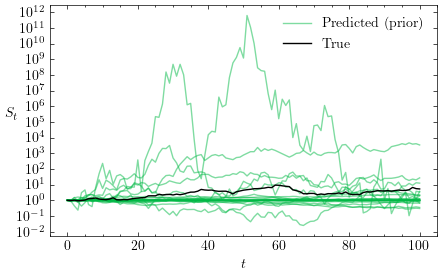

In [23]:
prior = torch.distributions.MultivariateNormal(torch.zeros(4), 1.0 * torch.eye(len(true_parameters)))
f, ax = plt.subplots(figsize=(5, 3))
j = 0
torch.manual_seed(0)
while j < 25:
    with torch.no_grad():
        prior_pred = model.run_and_observe(prior.sample((1,))[0])
        if torch.isnan(prior_pred[0]).any():
            continue
        j += 1
    prior_prices = torch.cumprod(torch.exp(prior_pred[0].cpu()), dim=0)
    ax.plot(prior_prices, color = "C1", alpha=0.5)
true_prices = torch.cumprod(torch.exp(true_data[0]), dim=0)
ax.plot(true_prices, color = "black")

ax.plot([], [], color = "C1", label ="Predicted (prior)", alpha=0.5)
ax.plot([], [], color="black", label="True")

ax.set_ylabel(r"$S_t$", rotation=0)#, fontsize=12)
ax.set_xlabel(r"$t$")#, fontsize=12)

ax.set_yscale("symlog", linthresh=1e-5)
# ax.set_ylim([-0.016518938091961786, 57.77230358941138])

ax.legend()
# ax.get_ylim()

# plt.savefig("./ICAIF_plots/prior_preds.pdf", format='pdf', bbox_inches='tight', dpi=300)

### Training loss over time

In [24]:
import tensorflow as tf

In [25]:
path_losses = []
for path_summary in tf.compat.v1.train.summary_iterator("./runs/Oct04_12-38-02_CSL15270.local/events.out.tfevents.1696419482.CSL15270.local.7697.0"):
    for v in path_summary.summary.value:
        if v.tag == 'Loss/total':
            path_losses.append(v.simple_value)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [26]:
score_losses = []
for score_summary in tf.compat.v1.train.summary_iterator("./runs/Oct04_12-41-24_CSL15270.local/events.out.tfevents.1696419684.CSL15270.local.7697.1"):
    for v in score_summary.summary.value:
        if v.tag == 'Loss/total':
            score_losses.append(v.simple_value)

In [27]:
def smoothed(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [28]:
n_smooth = 10
tol = 1e-5
sm_score = smoothed([loss+1 for loss in score_losses], 
                    n_smooth)
sm_path = smoothed([loss+1 for loss in path_losses], 
                   n_smooth)

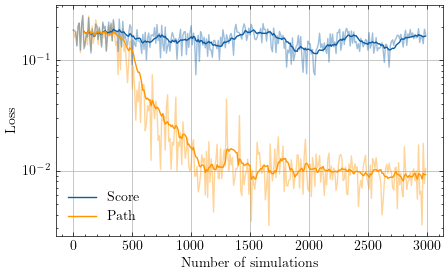

In [29]:
fig, ax = plt.subplots(figsize=(5, 3))
score_length = len(score_losses)
path_length = len(path_losses)
ax.plot(np.arange(path_length)*10,
        [loss + 1 + tol for loss in path_losses], 
        color="C2", alpha=0.4)
ax.plot(np.arange(score_length)*10,
        [loss + 1 + tol for loss in score_losses], 
        color="C0", alpha=0.4)
ax.plot(np.arange(n_smooth - 1, score_length)*10, sm_score, color="C0", label="Score")
ax.plot(np.arange(n_smooth - 1, path_length)*10, sm_path, color="C2", label="Path")
ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("Number of simulations")
ax.grid()

ax.set_yscale("log")

# plt.savefig("./ICAIF_plots/score_path_training_loss.pdf", format='pdf', bbox_inches='tight', dpi=300)